In [1]:
import numpy as np 
#import pylab 
import matplotlib.pyplot as plt

from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP 
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

In [2]:
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
distances = np.arange(0.5, 4.25, 0.25)
vqe_energies =[]
hf_energies =[]
exact_energies =[]

In [3]:
for i, d in enumerate(distances):
  print("steps", i)
  driver = PySCFDriver(molecule.format(d/2), basis = 'sto3g')
  qmolecule = driver.run()
  operator = Hamiltonian(qubit_mapping = QubitMappingType.PARITY, 
                         two_qubit_reduction= True, freeze_core = True,
                         orbital_reduction= [-3, -5])
  
  qubit_op, aux_ops = operator.run(qmolecule)

  #exact Numpy Solver
  exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
  exacet_result = operator.process_algorithm_result(exact_result)


  #VQE 
  optimizer = SLSQP(maxiter=1000)
  initial_states = HartreeFock(operator.molecule_info['num_orbitals'],
                               operator.molecule_info['num_particles'], 
                               qubit_mapping = operator._qubit_mapping, 
                               two_qubit_reduction= operator._two_qubit_reduction, 
                               )
  
  var_form = UCCSD(num_orbitals = operator.molecule_info['num_orbitals'], 
                  num_particles = operator.molecule_info['num_particles'],
                  initial_state = initial_states, 
                  qubit_mapping = operator._qubit_mapping, 
                  two_qubit_reduction= operator._two_qubit_reduction, 
                   )
  
  algo = VQE(qubit_op, var_form, optimizer, aux_operators = aux_ops)

  vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
  vqe_result = operator.process_algorithm_result(vqe_result)

  exact_energies.append(exacet_result.energy)
  vqe_energies.append(vqe_result.energy)
  hf_energies.append(vqe_result.hartree_fock_energy)

steps 0


/home/qulabs-sangru/anaconda3/envs/qiskit_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  import sys


steps 1


/home/qulabs-sangru/anaconda3/envs/qiskit_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  import sys


steps 2
steps 3
steps 4
steps 5
steps 6
steps 7
steps 8
steps 9
steps 10
steps 11
steps 12
steps 13
steps 14


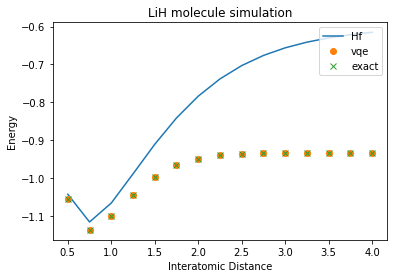

In [4]:
plt.plot(distances, hf_energies, label= 'Hf')
plt.plot(distances, vqe_energies, 'o', label= 'vqe')
plt.plot(distances, exact_energies, 'x', label= 'exact')

plt.xlabel("Interatomic Distance")
plt.ylabel("Energy")

plt.title("LiH molecule simulation")
plt.legend(loc='upper right')
